# Demo EMG Signal Classification

## 1. Data Preparation

After obtaining signal into *.csv, which follows as format of each row for signal values of `n` channels at a certain time `t` with the first row as the header name:

CH1,CH2,...,CH\<N\>
\<value11\>,\<value12\>,...,\<value1N\>
...
\<valueN1\>,\<valueN2\>,...,\<valueNN\>

In this example, we perform a classifier to classify 3 classes: `HandClose`, `HandOpen` and `Normal`. We can organize files into `train`, `validation`, and  `test` set. The `train` set is used to training classification model, `validation` set is used to validate trained model and help to find the best trained model during training process, while `test` set is present as secret set to evaluation the performance of trained model under the unknown data (the data which is not included into training process). The example of the dataset organization is stored in `data/classification_data`. In `data/classification_data`, the dataset has 3 main folders: `train`, `val`, `test`. In each main folder, each sub-folder contains signal for each classification label. In practice, the ratio of `train`/`val`/`test` is usually 90/5/5 or 80/10/10 or 70/15/15.

As previous demo, we need to processing the data to clean and segments them into small parts.

Import packages

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from filter import BandpassFilter1D, NotchFilter1D
from processing import MeanShift1D, Detrend1D, Resample1D, Normalize1D
from segment import SegmentND
from feature_extraction import *
%matplotlib inline

Processing functions

In [2]:
# process signal of each channel
def process_signal1d(x, raw_fs=1000, low_fs=1, high_fs=120, notch_fs=60, Q=20, window_size=250, step_size=50, target_fs=512):
    """
    @param x: signal of a single channel
    @param raw_fs: original sampling rate
    @param low_fs: low cutoff frequency
    @param high_fs: high cutoff frequency
    @param notch_fs: notch cutoff frequency
    @param Q: Q factor
    @param window_size: windows size for detrending
    @param step_size: step size for detrending
    @param target_fs: target sampling rate for resampling step
    """
    # mean-correct signal
    x_processed = MeanShift1D.apply(x)
    # filtering noise
    x_processed = BandpassFilter1D.apply(x_processed, low_fs, high_fs, order=4, fs=raw_fs)
    x_processed = NotchFilter1D.apply(x_processed, notch_fs, Q=Q, fs=raw_fs)
    # detrend
    x_processed = Detrend1D.apply(x_processed, detrend_type='locreg', window_size=window_size, step_size=step_size)
    # resample
    x_processed = Resample1D.apply(x_processed, raw_fs, target_fs)
    # rectify
    x_processed = abs(x_processed)
    # normalize
    x_processed = Normalize1D.apply(x_processed, norm_type='min_max')
    return x_processed

In [3]:
# process multi-channel signal
def process_signalnd(x, raw_fs=1000, low_fs=1, high_fs=120, notch_fs=60, Q=20, window_size=250, step_size=50, target_fs=512):
    """
    @param x: signal of a single channel
    @param raw_fs: original sampling rate
    @param low_fs: low cutoff frequency
    @param high_fs: high cutoff frequency
    @param notch_fs: notch cutoff frequency
    @param Q: Q factor
    @param window_size: windows size for detrending
    @param step_size: step size for detrending
    @param target_fs: target sampling rate for resampling step
    """
    num_channels = x.shape[1]
    x_processed = np.array([])
    for i in range(num_channels):
        # process each channel
        channel_processed = process_signal1d(x[:, i], raw_fs, low_fs, high_fs, notch_fs, Q, window_size, step_size, target_fs)
        channel_processed = np.expand_dims(channel_processed, axis=1)
        if i == 0:
            x_processed = channel_processed
            continue
        x_processed = np.hstack((x_processed, channel_processed))
    return x_processed

Load data and segmentation.

In [4]:
# parameters for clean data
raw_fs = 1000
target_fs = 512
low_fs = 10
high_fs = 120
notch_fs = 60
Q = 20
windows = 512
steps = 50
# segment parameters
seg_window_size = 512
seg_step_size = 32
# data root
data_root = './EMG_data/classification_data'
root = Path(data_root)
data = {}
label = {}
for sub in root.iterdir():
    data[sub.name] = [] # create list for `train`,`val`,`test data segments
    label[sub.name] = [] # create list for label of data segments
    for subsub in sub.iterdir():
        if subsub.name == 'Normal':
            y = 0   # set `Normal` class as 0
        elif subsub.name == 'FistMedium':
            y = 1   # set `HandOpen` class as 1
        elif subsub.name == 'Left':
            y = 2   # set `HandClose` class as 2
        for filename in subsub.iterdir():
            # load raw signal from file
            emg_raw = pd.read_csv(str(filename)).values
            # clean raw signal
            emg_processed = process_signalnd(emg_raw, raw_fs, low_fs, high_fs, notch_fs, Q, windows, steps, target_fs)
            # segment signal
            signal_segments = SegmentND.apply(emg_processed, seg_window_size, seg_step_size)
            data[sub.name].extend(signal_segments)
            label[sub.name].extend([y] * len(signal_segments))
print('Number of train samples (X, Y) = ({}, {})'.format(len(data['train']), len(label['train'])))
print('Number of val samples   (X, Y) = ({}, {})'.format(len(data['val']), len(label['val'])))
print('Number of test samples  (X, Y) = ({}, {})'.format(len(data['test']), len(label['test'])))

Number of train samples (X, Y) = (3456, 3456)
Number of val samples   (X, Y) = (432, 432)
Number of test samples  (X, Y) = (432, 432)


## Feature extraction

Before feeding data to train classifier, we need to extract feature. We use features as described in `demo_signal_feature_extraction.ipynb`.

In this example, we will try to use the Time domain features: `Maximum Peak Value`, `Mean`, `Variance`, `Standarddeviation`, `Skewness`, `Kurtosis`, `Root Mean Square`. Because these features are multi-channel features with **2D** dimension, we need to flatten them into **1D**. Moreover, we also want to combine different features together by **Concatenating** or **Pooling**. Concatenting means the feature vectors are concatenated into one final feature vector. There are 2 common **Pooling** strategies for **Pooling**: **Average Pooling** and **Max/Min Pooling**. **Average Pooling** means the average values of features is computed as the final feature vector, while **Max/Min Pooling** means the max/min values among extracted feature as the final feature vector.

In [5]:
# process X
X = {}
Y = {}
feature_windows_size = 10
concat = True
avg_pool = True
print('please wait....')
for set in data.keys():
    print(set)
    Y[set] = np.array(label[set])
    X[set] = np.array([])
    for seg in data[set]:
        # extract, transpose and flatten feature vectors
        peak = MaxPeak.apply(seg, feature_windows_size).T.flatten()
        mean = Mean.apply(seg, feature_windows_size).T.flatten()
        var = Variance.apply(seg, feature_windows_size).T.flatten()
        std = StandardDeviation.apply(seg, feature_windows_size).T.flatten()
        skew = Skewness.apply(seg, feature_windows_size).T.flatten()
        kurt = Kurtosis.apply(seg, feature_windows_size).T.flatten()
        rms = RootMeanSquare.apply(seg, feature_windows_size).T.flatten()
        if concat:
            feature = np.hstack([peak, mean, var, std, skew, kurt, rms])
            feature = np.expand_dims(feature, axis=0)
        else:
            feature = np.vstack([peak, mean, var, std, skew, kurt, rms])
            if avg_pool:
                # average pooling
                feature = feature.mean(axis=0)
            else:
                # max pooling
                feature = feature.max(axis=0)
            feature = np.expand_dims(feature, axis=0)
        if X[set].size == 0:
            X[set] = feature
            continue
        X[set] = np.vstack([X[set], feature])
print('Number of samples X[train]: ', len(X['train']))
print('Number of samples X[val]: ', len(X['val']))
print('Number of samples X[test]: ', len(X['test']))

please wait....
test
train
val
Number of samples X[train]:  3456
Number of samples X[val]:  432
Number of samples X[test]:  432


In [6]:
print('Feature length of X[train]:', X['train'].shape[1])
print('Feature length of X[val]:', X['val'].shape[1])
print('Feature length of X[val]:', X['test'].shape[1])

Feature length of X[train]: 364
Feature length of X[val]: 364
Feature length of X[val]: 364


## Dimensionality Reduction

One that we have obtain feature vector, in order to increase the performance of the classifier it is advisable to reduce its dimensionality by keeping the representative information in the feature vector and eliminating the redundant one from it. the resulting vector is called reduced feature vector.

**Principal component analysis (PCA)** as a **feature projection** technique of dimensional reduction. It is an orthogonal linear transformation that can be used for dimensionality reduction in a signal dataset by retaining those characteristics of dataset that contribute most to its variance. In order to do this, lower-order principal components are kept and high-order ones are dismissed.

We can use PCA in **scikit-learn** library to reduce feature dimensionality. Note that you apply PCA for **training process**.

In [7]:
from sklearn.decomposition import PCA

In [8]:
num_components = 128
pca = PCA(n_components=num_components)
pca.fit(X['train'])
X['train'] = pca.transform(X['train'])
X['val'] = pca.transform(X['val'])
X['test'] = pca.transform(X['test'])
print('Feature length of X[train]', X['train'].shape[1])

Feature length of X[train] 128


Save PCA to use for real-time inference.

In [9]:
import pickle as pk
pk.dump(pca, open('pca.pkl', 'wb'))

# Classification

# KNN Classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

You can read the document from [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to fine-tune your model.

In [11]:
K = 5
knn_cls = KNeighborsClassifier(n_neighbors=K, p=1)
knn_cls.fit(X['train'], Y['train'])

KNeighborsClassifier(p=1)

Get the prediction from input X

In [12]:
Y_preds = knn_cls.predict(X['val'])

In [13]:
from visualize import plot_confusion_matrix, display_model_performance

Show accuracy of model. The `display_model_performance` function helps you evaluate your train model's performance.

In [14]:
display_model_performance(Y['val'], Y_preds, classes=[0, 1, 2])

Model metrics:
------------------------------
Accuracy: 0.5509
Precision: 0.6791
Recall: 0.5509
F1 Score: 0.5027

Model classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       144
           1       0.73      0.47      0.57       144
           2       0.84      0.18      0.30       144

    accuracy                           0.55       432
   macro avg       0.68      0.55      0.50       432
weighted avg       0.68      0.55      0.50       432



Plot confusion matrix.

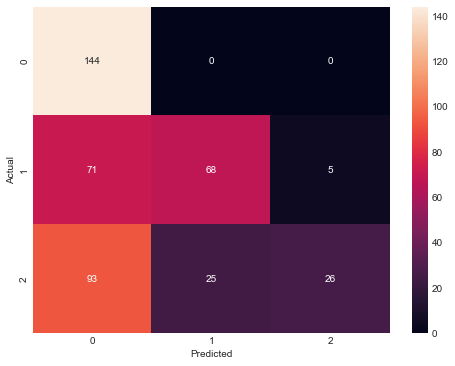

In [15]:
plot_confusion_matrix(Y['val'], Y_preds, labels=[0, 1, 2], save_name='VAL_KNN_CONFUSION_MATRIX')

## SVM Classifier

In [16]:
from sklearn.svm import SVC

You can read the document from [https://scikit-learn.org/stable/modules/svm.html#svm](https://scikit-learn.org/stable/modules/svm.html#svm) for more understanding of using scikit-learn's SVM.

In [17]:
svc_cls = SVC()
svc_cls.fit(X['train'], Y['train'])

SVC()

Get prediction from input X.

In [18]:
Y_preds = svc_cls.predict(X['val'])

Show accuracy of model. The `display_model_performance` function helps you evaluate your train model's performance.

In [19]:
display_model_performance(Y['val'], Y_preds, classes=[0, 1, 2])

Model metrics:
------------------------------
Accuracy: 0.9282
Precision: 0.9396
Recall: 0.9282
F1 Score: 0.9275

Model classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       144
           1       0.99      0.79      0.88       144
           2       0.83      1.00      0.91       144

    accuracy                           0.93       432
   macro avg       0.94      0.93      0.93       432
weighted avg       0.94      0.93      0.93       432



Plot the confusion matrix.

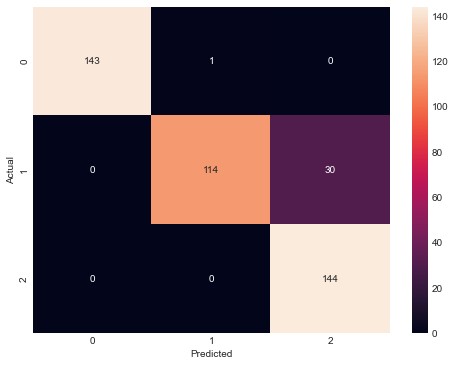

In [20]:
plot_confusion_matrix(Y['val'], Y_preds, [0, 1, 2], save_name='VAL_SVM_CONFUSION_MATRIX')

After training a good model, which has high accuracy, you can evaluate your model by `test` set.  To enchance your model, you can **collect more data and train again**.

In [21]:
Y_test_preds = svc_cls.predict(X['test'])

Show the test accuracy.

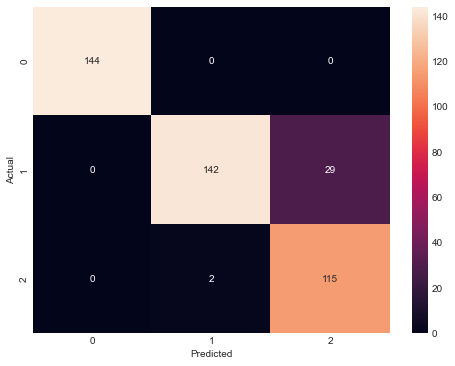

In [22]:
plot_confusion_matrix(Y_test_preds, Y['test'], labels=[0, 1, 2], save_name='TEST_SVM_CONFUSION_MATRIX')

The results on test set show that the train model **cannot** predict well with class 0. You can **collect more data** or **change arguments in SVM function**.

Save the trained model to use real-time inference.

In [23]:
pk.dump(svc_cls, open('svc.pkl', 'wb'))